## assignment 04: Decision Tree construction

In [1]:
# If working in colab, uncomment the following line
#! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_made/homeworks/assignment0_04_tree/tree.py -nc

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import numpy as np
from sklearn.base import BaseEstimator


def entropy(y):  
    """
    Computes entropy of the provided distribution. Use log(value + eps) for numerical stability
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, n_classes)
        One-hot representation of class labels for corresponding subset
    
    Returns
    -------
    float
        Entropy of the provided subset
    """
    EPS = 0.0005
    obj, cl = y.shape
    x = np.sum(y, axis=0) / obj
    return -np.sum(np.multiply(x, np.log(EPS + x)))
    
def gini(y):
    """
    Computes the Gini impurity of the provided distribution
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, n_classes)
        One-hot representation of class labels for corresponding subset
    
    Returns
    -------
    float
        Gini impurity of the provided subset
    """
    return 1. - np.sum(np.mean(y, axis=0) ** 2)
    
def variance(y):
    """
    Computes the variance the provided target values subset
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, 1)
        Target values vector
    
    Returns
    -------
    float
        Variance of the provided target vector
    """
    
    return np.var(y)

def mad_median(y):
    """
    Computes the mean absolute deviation from the median in the
    provided target values subset
    
    Parameters
    ----------
    y : np.array of type float with shape (n_objects, 1)
        Target values vector
    
    Returns
    -------
    float
        Mean absolute deviation from the median in the provided vector
    """
    return np.mean(np.abs(y - np.median(y)))


def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype=float)
    y_one_hot[np.arange(len(y)), y.astype(int)[:, 0]] = 1.
    return y_one_hot


def one_hot_decode(y_one_hot):
    return y_one_hot.argmax(axis=1)[:, None]


class Node:
    """
    This class is provided "as is" and it is not mandatory to it use in your code.
    """
    def __init__(self, feature_index, threshold, proba=0):
        self.feature_index = feature_index
        self.value = threshold
        self.proba = proba
        self.left_child = None
        self.right_child = None
        
        
class DecisionTree(BaseEstimator):
    all_criterions = {
        'gini': (gini, True), # (criterion, classification flag)
        'entropy': (entropy, True),
        'variance': (variance, False),
        'mad_median': (mad_median, False)
    }

    def __init__(self, n_classes=None, max_depth=np.inf, min_samples_split=2, 
                 criterion_name='gini', debug=False):

        assert criterion_name in self.all_criterions.keys(), 'Criterion name must be on of the following: {}'.format(self.all_criterions.keys())
        
        self.n_classes = n_classes
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion_name = criterion_name

        self.depth = 0
        self.root = None # Use the Node class to initialize it later
        self.debug = debug

        
        
    def make_split(self, feature_index, threshold, X_subset, y_subset):
        """
        Makes split of the provided data subset and target values using provided feature and threshold
        
        Parameters
        ----------
        feature_index : int
            Index of feature to make split with

        threshold : float
            Threshold value to perform split

        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels for corresponding subset
        
        Returns
        -------
        (X_left, y_left) : tuple of np.arrays of same type as input X_subset and y_subset
            Part of the providev subset where selected feature x^j < threshold
        (X_right, y_right) : tuple of np.arrays of same type as input X_subset and y_subset
            Part of the providev subset where selected feature x^j >= threshold
        """
        s = X_subset[:, feature_index] < threshold
        y_left = y_subset[s]
        X_left = X_subset[s]
        y_right = y_subset[~s] 
        X_right = X_subset[~s]
        return (X_left, y_left), (X_right, y_right)
    
    def make_split_only_y(self, feature_index, threshold, X_subset, y_subset):
        """
        Split only target values into two subsets with specified feature and threshold
        
        Parameters
        ----------
        feature_index : int
            Index of feature to make split with

        threshold : float
            Threshold value to perform split

        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels for corresponding subset
        
        Returns
        -------
        y_left : np.array of type float with shape (n_objects_left, n_classes) in classification 
                   (n_objects, 1) in regression 
            Part of the provided subset where selected feature x^j < threshold

        y_right : np.array of type float with shape (n_objects_right, n_classes) in classification 
                   (n_objects, 1) in regression 
            Part of the provided subset where selected feature x^j >= threshold
        """
        y_left = y_subset[X_subset[:, feature_index] < threshold]
        y_right = y_subset[X_subset[:, feature_index] >= threshold]

        return y_left, y_right

    def choose_best_split(self, X_subset, y_subset):
        """
        Greedily select the best feature and best threshold w.r.t. selected criterion
        
        Parameters
        ----------
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels or target values for corresponding subset
        
        Returns
        -------
        feature_index : int
            Index of feature to make split with

        threshold : float
            Threshold value to perform split

        """
        func = self.all_criterions[self.criterion_name][0]
        feature_index = 0
        threshold = 0
        g = -np.inf
        obj, features = X_subset.shape
        
        for index in range(features):
            # Leave only unique feature values for optimizing split choice
            thresh_arr = np.unique(X_subset[:, index])
            
            for thresh_i in thresh_arr:
                y_left, y_right = self.make_split_only_y(index, thresh_i, X_subset, y_subset)
                
                newg = func(y_subset) - (len(y_left) * func(y_left) + len(y_right) * func(y_right)) / obj
                
                if newg > g:
                    g = newg
                    feature_index = index
                    threshold = thresh_i      
        
        return feature_index, threshold
    
    def make_tree(self, X_subset, y_subset):
        """
        Recursively builds the tree
        
        Parameters
        ----------
        X_subset : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the selected subset

        y_subset : np.array of type float with shape (n_objects, n_classes) in classification 
                   (n_objects, 1) in regression 
            One-hot representation of class labels or target values for corresponding subset
        
        Returns
        -------
        root_node : Node class instance
            Node of the root of the fitted tree
        """
        
        self.depth += 1
        new_node = None
        
        obj, features = X_subset.shape
        
        if self.min_samples_split <= obj and self.max_depth > self.depth:
            feature_index, threshold = self.choose_best_split(X_subset, y_subset)
            new_node = Node(feature_index, threshold)
            left, right = self.make_split(feature_index, threshold, X_subset, y_subset)
            new_node.right_child = self.make_tree(*right)
            new_node.left_child = self.make_tree(*left)
        else:
            new_node = Node(0, 0)
            if self.classification:
                new_node.probas = np.mean(y_subset, axis=0)
                new_node.value = np.argmax(np.sum(y_subset, axis=0))
            elif self.criterion_name == "mad_median":
                new_node.value = np.median(y_subset)
            elif self.criterion_name == "variance":
                new_node.value = np.mean(y_subset)
        self.depth -= 1
        
        return new_node
        
    def fit(self, X, y):
        """
        Fit the model from scratch using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data to train on

        y : np.array of type int with shape (n_objects, 1) in classification 
                   of type float with shape (n_objects, 1) in regression 
            Column vector of class labels in classification or target values in regression
        
        """
        assert len(y.shape) == 2 and len(y) == len(X), 'Wrong y shape'
        self.criterion, self.classification = self.all_criterions[self.criterion_name]
        if self.classification:
            if self.n_classes is None:
                self.n_classes = len(np.unique(y))
            y = one_hot_encode(self.n_classes, y)

        self.root = self.make_tree(X, y)
    
    def predict(self, X):
        """
        Predict the target value or class label  the model from scratch using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data the predictions should be provided for

        Returns
        -------
        y_predicted : np.array of type int with shape (n_objects, 1) in classification 
                   (n_objects, 1) in regression 
            Column vector of class labels in classification or target values in regression
        
        """

        obj, features = X.shape
        
        y_predicted = np.zeros((obj, 1))
        y = np.arange(obj)
        for i in range(obj):
            current = self.root
            while current.left_child is not None:
                if X[i][current.feature_index] > current.value:     
                    current = current.right_child
                else:
                    current = current.left_child
            y_predicted[i] = current.value
        
        return y_predicted
        
    def predict_proba(self, X):
        """
        Only for classification
        Predict the class probabilities using the provided data
        
        Parameters
        ----------
        X : np.array of type float with shape (n_objects, n_features)
            Feature matrix representing the data the predictions should be provided for

        Returns
        -------
        y_predicted_probs : np.array of type float with shape (n_objects, n_classes)
            Probabilities of each class for the provided objects
        
        """
        assert self.classification, 'Available only for classification problem'

        obj, features = X.shape
        y = np.arange(obj)
                
        y_predicted_probas = np.zeros((obj, self.n_classes))
        
        for i in range(obj):
            current = self.root
            while current.left_child is not None:
                if X[i][current.feature_index] > current.value:
                    current = current.right_child
                else:
                    current = current.left_child
                    
            y_predicted_probas[i] = current.probas
        
        return y_predicted_probas

In [24]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's fix the `random_state` (a.k.a. random seed).

In [25]:
RANDOM_STATE = 42

__Your ultimate task for today is to impement the `DecisionTree` class and use it to solve classification and regression problems.__

__Specifications:__
- The class inherits from `sklearn.BaseEstimator`;
- Constructor is implemented for you. It has the following parameters:
    * `max_depth` - maximum depth of the tree; `np.inf` by default
    * `min_samples_split` - minimal number of samples in the leaf to make a split; `2` by default;
    * `criterion` - criterion to select the best split; in classification one of `['gini', 'entropy']`, default `gini`; in regression `variance`;

- `fit` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and `y` (`numpy.array` of type float shaped `(n_objects, 1)` in regression; `numpy.array` of type int shaped `(n_objects, 1)` with class labels in classification). It works inplace and fits the `DecisionTree` class instance to the provided data from scratch.

- `predict` method takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the predicted $\hat{y}$ values. In classification it is a class label for every object (the most frequent in the leaf; if several classes meet this requirement select the one with the smallest class index). In regression it is the desired constant (e.g. mean value for `variance` criterion)

- `predict_proba` method (works only for classification (`gini` or `entropy` criterion). It takes `X` (`numpy.array` of type `float` shaped `(n_objects, n_features)`) and returns the `numpy.array` of type `float` shaped `(n_objects, n_features)` with class probabilities for every object from `X`. Class $i$ probability equals the ratio of $i$ class objects that got in this node in the training set.

    
__Small recap:__

To find the optimal split the following functional is evaluated:
    
$$G(j, t) = H(Q) - \dfrac{|L|}{|Q|} H(L) - \dfrac{|R|}{|Q|} H(R),$$
    where $Q$ is the dataset from the current node, $L$ and $R$ are left and right subsets defined by the split $x^{(j)} < t$.



1. Classification. Let $p_i$ be the probability of $i$ class in subset $X$ (ratio of the $i$ class objects in the dataset). The criterions are defined as:
    
    * `gini`: Gini impurity $$H(R) = 1 -\sum_{i = 1}^K p_i^2$$
    
    * `entropy`: Entropy $$H(R) = -\sum_{i = 1}^K p_i \log(p_i)$$ (One might use the natural logarithm).
    
2. Regression. Let $y_l$ be the target value for the $R$, $\mathbf{y} = (y_1, \dots, y_N)$ – all targets for the selected dataset $X$.
    
    * `variance`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}(y_j - \text{mean}(\mathbf{y}))^2$$
    
    * `mad_median`: $$H(R) = \dfrac{1}{|R|} \sum_{y_j \in R}|y_j - \text{median}(\mathbf{y})|$$
        


**Hints and comments**:

* No need to deal with categorical features, they will not be present.
* Siple greedy recursive procedure is enough. However, you can speed it up somehow (e.g. using percentiles).
* Please, do not copy implementations available online. You are supposed to build very simple example of the Decision Tree.

File `tree.py` is waiting for you. Implement all the needed methods in that file.

### Check yourself

#### Simple check

In [26]:
X = np.ones((4, 5), dtype=float) * np.arange(4)[:, None]
y = np.arange(4)[:, None] + np.asarray([0.2, -0.3, 0.1, 0.4])[:, None]
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')

(X_l, y_l), (X_r, y_r) = class_estimator.make_split(1, 1., X, y)

assert np.array_equal(X[:1], X_l)
assert np.array_equal(X[1:], X_r)
assert np.array_equal(y[:1], y_l)
assert np.array_equal(y[1:], y_r)

#### Classification problem

In [27]:
digits_data = load_digits().data
digits_target = load_digits().target[:, None] # to make the targets consistent with our model interfaces
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits_target, test_size=0.2, random_state=RANDOM_STATE)

In [28]:
assert len(y_train.shape) == 2 and y_train.shape[0] == len(X_train)

In [29]:
class_estimator = DecisionTree(max_depth=10, criterion_name='gini')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_gini = accuracy_score(y_test, ans)
print(accuracy_gini)

0.825


In [30]:
reference = np.array([0.09027778, 0.09236111, 0.08333333, 0.09583333, 0.11944444,
       0.13888889, 0.09930556, 0.09444444, 0.08055556, 0.10555556])

In [31]:
class_estimator = DecisionTree(max_depth=10, criterion_name='entropy')
class_estimator.fit(X_train, y_train)
ans = class_estimator.predict(X_test)
accuracy_entropy = accuracy_score(y_test, ans)
print(accuracy_entropy)

0.8416666666666667


In [32]:
assert  0.82 < accuracy_gini < 0.9
assert  0.84 < accuracy_entropy < 0.9
assert np.sum(np.abs(class_estimator.predict_proba(X_test).mean(axis=0) - reference)) < 1e-1

Let's use 5-fold cross validation (`GridSearchCV`) to find optimal values for `max_depth` and `criterion` hyperparameters.

In [33]:
param_grid = {'max_depth': range(3,11), 'criterion_name': ['gini', 'entropy']}
gs = GridSearchCV(DecisionTree(), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-2)

In [34]:
%%time
gs.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3

/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipykernel_50892/2612795556.py:21: RuntimeWarning: invalid value encountered in divide
/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipykernel_50892/2612795556.py:21: RuntimeWarning: invalid value encountered in divide
/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipykernel_50892/2612795556.py:21: RuntimeWarning: invalid value encountered in divide
/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipykernel_50892/2612795556.py:21: RuntimeWarning: invalid value encountered in divide
/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipykernel_50892/2612795556.py:21: RuntimeWarning: invalid value encountered in divide
/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipykernel_50892/2612795556.py:21: RuntimeWarning: invalid value encountered in divide
/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipykernel_50892/2612795556.py:21: RuntimeWarning: invalid value encountered in divide
/var/folders/rg/78pvh53103n22rh3t4d5p2tw0000gn/T/ipyker

CPU times: user 5.41 s, sys: 98 ms, total: 5.51 s
Wall time: 33 s


GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['gini', 'entropy'],
                         'max_depth': range(3, 11)},
             scoring='accuracy')

In [35]:
gs.best_params_

{'criterion_name': 'entropy', 'max_depth': 10}

In [37]:
assert gs.best_params_['criterion_name'] == 'entropy'
assert 6 < gs.best_params_['max_depth'] < 11

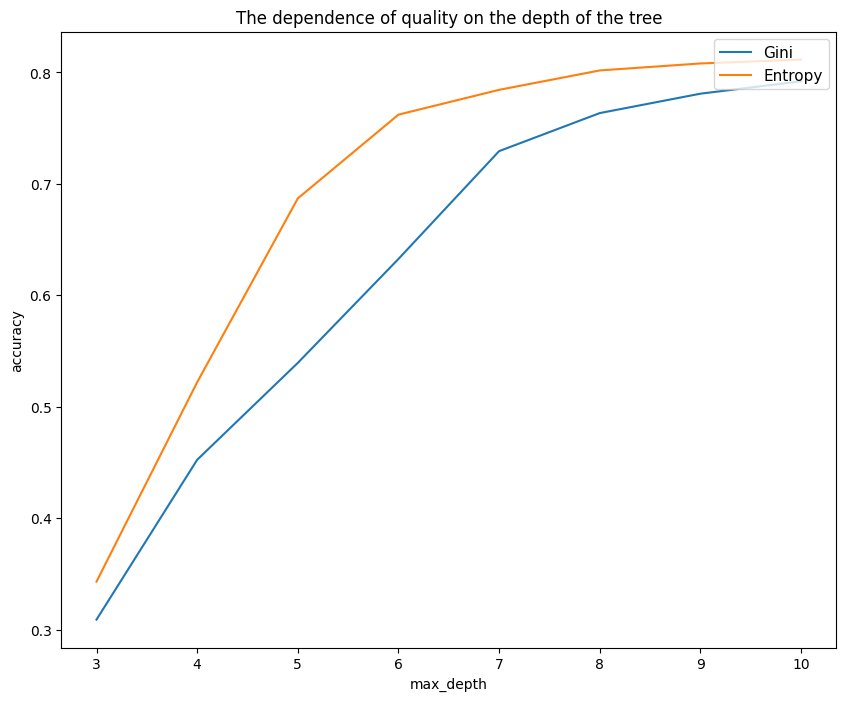

In [38]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of quality on the depth of the tree")
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][:8], label='Gini')
plt.plot(np.arange(3,11), gs.cv_results_['mean_test_score'][8:], label='Entropy')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('accuracy')
plt.show()

#### Regression problem

In [39]:
regr_data = load_boston().data
regr_target = load_boston().target[:, None] # to make the targets consistent with our model interfaces
RX_train, RX_test, Ry_train, Ry_test = train_test_split(regr_data, regr_target, test_size=0.2, random_state=RANDOM_STATE)

In [40]:
regressor = DecisionTree(max_depth=10, criterion_name='mad_median')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_mad = mean_squared_error(Ry_test, predictions_mad)
print(mse_mad)

12.276151960784313


In [41]:
regressor = DecisionTree(max_depth=10, criterion_name='variance')
regressor.fit(RX_train, Ry_train)
predictions_mad = regressor.predict(RX_test)
mse_var = mean_squared_error(Ry_test, predictions_mad)
print(mse_var)

10.02845219289886


In [42]:
assert 9 < mse_mad < 20
assert 8 < mse_var < 12

In [43]:
param_grid_R = {'max_depth': range(2,9), 'criterion_name': ['variance', 'mad_median']}

In [44]:
gs_R = GridSearchCV(DecisionTree(), param_grid=param_grid_R, cv=5, scoring='neg_mean_squared_error', n_jobs=-2)
gs_R.fit(RX_train, Ry_train)

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/cor

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/cor

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/an

GridSearchCV(cv=5, estimator=DecisionTree(), n_jobs=-2,
             param_grid={'criterion_name': ['variance', 'mad_median'],
                         'max_depth': range(2, 9)},
             scoring='neg_mean_squared_error')

In [45]:
gs_R.best_params_

{'criterion_name': 'mad_median', 'max_depth': 5}

In [46]:
assert gs_R.best_params_['criterion_name'] == 'mad_median'
assert 3 < gs_R.best_params_['max_depth'] < 7

In [47]:
var_scores = gs_R.cv_results_['mean_test_score'][:7]
mad_scores = gs_R.cv_results_['mean_test_score'][7:]

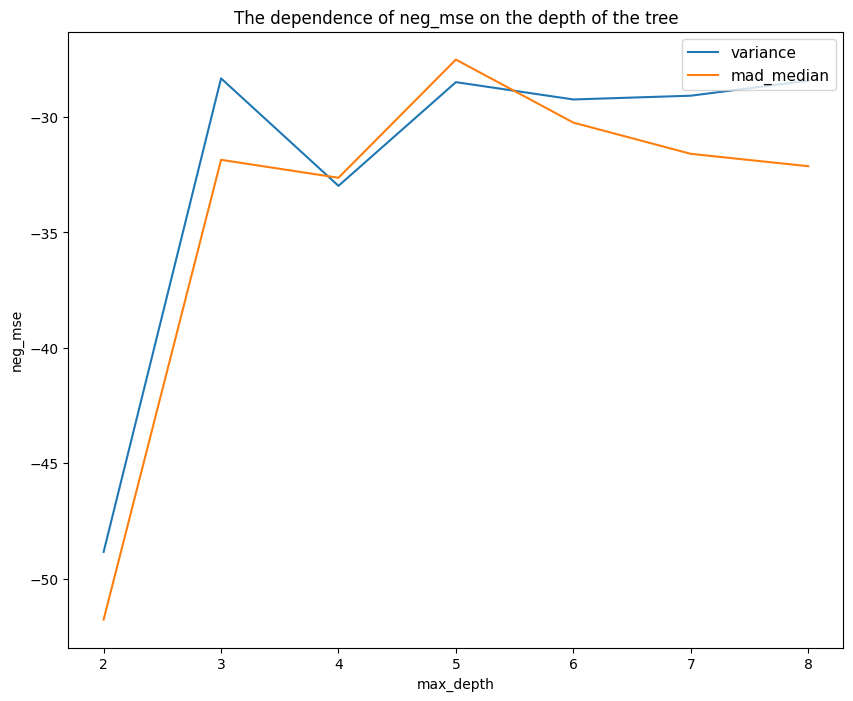

In [48]:
plt.figure(figsize=(10, 8))
plt.title("The dependence of neg_mse on the depth of the tree")
plt.plot(np.arange(2,9), var_scores, label='variance')
plt.plot(np.arange(2,9), mad_scores, label='mad_median')
plt.legend(fontsize=11, loc=1)
plt.xlabel("max_depth")
plt.ylabel('neg_mse')
plt.show()